# Mandatory Task 2a

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [12]:
states_df_out = pd.read_csv("States Data/22_cleaned.csv").drop(['Unnamed: 0'],axis=1)
states_df_out.shape

(376, 5)

In [13]:
states_df_2a = states_df_out[((states_df_out['Date'] >= '2020-08-01') & (states_df_out['Date'] <= '2020-08-31'))]
states_df_2a.shape

(31, 5)

In [14]:
train, test = states_df_2a[0:-7],states_df_2a[-7:]

## AR with p = 3 and 5 

In [15]:
def getMSEandMAPE(actual, prediction):
    mse = 0
    mape = 0
    for x in range(len(actual)):
        mse += np.square(prediction[x] - actual[x])
        mape += abs(actual[x] - prediction[x])/actual[x]
    mse = mse/len(actual)
    mape = (mape/len(actual))*100
    return mse, mape 

In [22]:
def plotGraph(date, actual, prediction):
    plt.plot(date,actual,label="Actual")
    plt.plot(date,prediction,label="Prediction")
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend(loc='upper left')
    plt.xticks(rotation=30)
    plt.show()

In [24]:
def trainAR(data,p,curLen):
    X = []
    Y = []
    for i in range(curLen):
        if i+p < curLen :
            X.append([1] + list(data[i:i+p]))
            Y.append(data[i+p])            
        else:
            break
    return X, Y

def getBetaValues(X,Y):
    beta=np.matmul(np.linalg.inv(np.matmul(np.transpose(X),X)),np.matmul(np.transpose(X),Y))
    return beta

def predictAR(train, test, p):
    data = np.hstack([train, test])
    trainLen = data.shape[0] - test.shape[0] 
    predictions = np.zeros(test.shape[0])
    for i in range(trainLen,data.shape[0]):
        dat = np.hstack([[1], data[i-p:i]])
        X,Y = ar_train(data, p, i)
        beta = getBetaValues(X,Y)
        predictions[i-trainLen] = np.matmul(dat,beta)

    return predictions

 ---------------  TN confirmed  ----------------------  

         Date  Actual    Predicted
0  2020-08-25   813.0  1682.735460
1  2020-08-26  1936.0  1419.627093
2  2020-08-27  1826.0  1718.582469
3  2020-08-28  1636.0  1634.727556
4  2020-08-29  1465.0  1579.627186
5  2020-08-30   835.0  1571.120433
6  2020-08-31  1818.0  1475.304503 

MSE :  243867.6831167538  MAPE :  36.34911235351231 




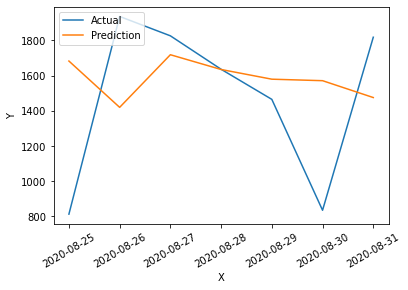




 ---------------  TX confirmed  ----------------------  

         Date  Actual    Predicted
0  2020-08-25  6397.0  4514.706349
1  2020-08-26  5445.0  6367.400933
2  2020-08-27  5694.0  5893.878577
3  2020-08-28  4150.0  6077.947372
4  2020-08-29  4733.0  5312.722264
5  2020-08-30  3761.0  5401.093170
6  2020-08-31  2550.0  4753.796890 

MSE :  2290498.517660823  MAPE :  34.08738360474345 




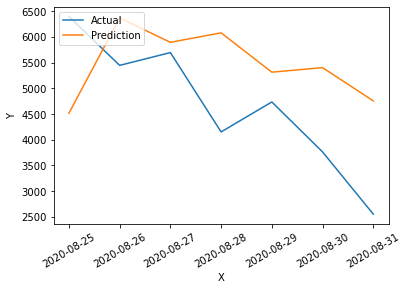




 ---------------  TN deaths  ----------------------  

         Date  Actual  Predicted
0  2020-08-25    40.0  27.932749
1  2020-08-26    20.0  29.877670
2  2020-08-27    25.0  19.024509
3  2020-08-28    28.0  23.921775
4  2020-08-29    24.0  24.715985
5  2020-08-30    22.0  23.070699
6  2020-08-31     7.0  23.523434 

MSE :  81.45831841988749  MAPE :  51.70323903348406 




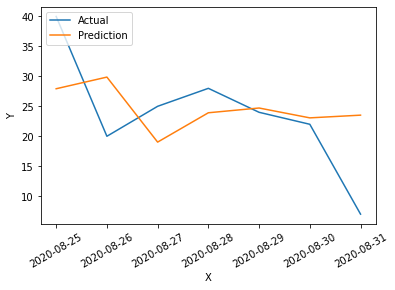




 ---------------  TX deaths  ----------------------  

         Date  Actual   Predicted
0  2020-08-25   181.0  138.099671
1  2020-08-26   229.0  292.103796
2  2020-08-27   265.0  257.573662
3  2020-08-28   196.0  233.817839
4  2020-08-29   154.0  171.750801
5  2020-08-30    90.0  169.063178
6  2020-08-31    26.0  157.386058 

MSE :  4448.034264031154  MAPE :  96.86582137300273 




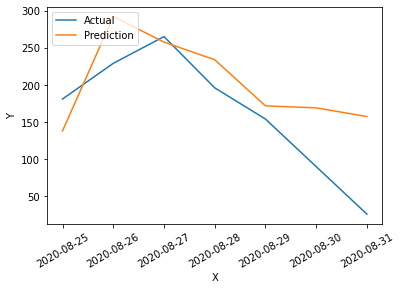

In [27]:
cols = ['TN confirmed', 'TX confirmed', 'TN deaths', 'TX deaths']
date = np.array(test['Date'])
for col in cols:
    
    actual = np.array(test[col])
    prediction = predictAR(np.array(train[col]),np.array(test[col]), 3)
    
    df_ar1 = pd.DataFrame()
    df_ar1['Date'] = date
    df_ar1['Actual'] = actual
    df_ar1['Predicted'] = prediction
    print('\033[1m --------------- ',col,' ---------------------- \033[0m \n')
    print(df_ar1, '\n')
    
    mse, mape = getMSEandMAPE(actual,prediction)
    print('MSE : ', mse, ' MAPE : ', mape, '\n\n')
    
    plotGraph(date, actual, prediction)
    
    print('\n\n')

## EMWA with alpha = 0.5 and 0.8

In [28]:
def EWMA(data, alpha):

    y_pred = []
    y_pred.append(data[0])
    for i in range(1,len(data)):
        y_pred.append(alpha * data[i-1] + (1 - alpha) * y_pred[i-1])

    y_actual = data
    #Computing MSE and MAPE for test set
    MSE, MAPE = getMSEandMAPE(y_pred[-7:], y_actual[-7:])
    return y_pred,MSE,MAPE

 ---------------  TN confirmed  ----------------------  

         Date  Actual  Predicted_EWMA(0.5)  Predicted_EWMA(0.8)
0  2020-08-25     NaN          1149.772742           882.915525
1  2020-08-26     NaN           981.386371           826.983105
2  2020-08-27     NaN          1458.693185          1714.196621
3  2020-08-28     NaN          1642.346593          1803.639324
4  2020-08-29     NaN          1639.173296          1669.527865
5  2020-08-30     NaN          1552.086648          1505.905573
6  2020-08-31     NaN          1193.543324           969.181115 


   Alpha            MSE       MAPE
0    0.5  299164.767727  37.325142
1    0.8  355407.004003  43.174667 


		Alpha = 0.5


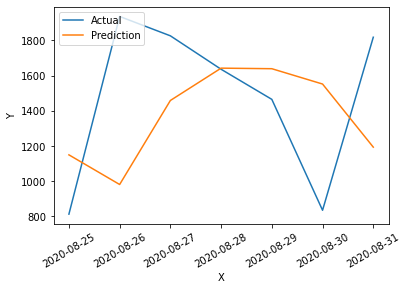




		Alpha = 0.8


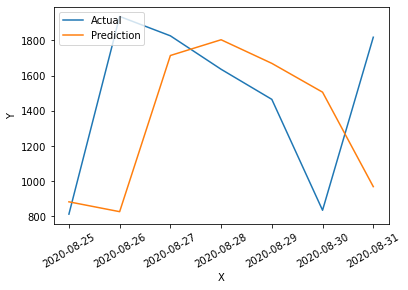




 ---------------  TX confirmed  ----------------------  

         Date  Actual  Predicted_EWMA(0.5)  Predicted_EWMA(0.8)
0  2020-08-25     NaN          3918.991362          3185.316248
1  2020-08-26     NaN          5157.995681          5754.663250
2  2020-08-27     NaN          5301.497840          5506.932650
3  2020-08-28     NaN          5497.748920          5656.586530
4  2020-08-29     NaN          4823.874460          4451.317306
5  2020-08-30     NaN          4778.437230          4676.663461
6  2020-08-31     NaN          4269.718615          3944.132692 


   Alpha           MSE       MAPE
0    0.5  1.742036e+06  23.452344
1    0.8  2.225285e+06  28.213501 


		Alpha = 0.5


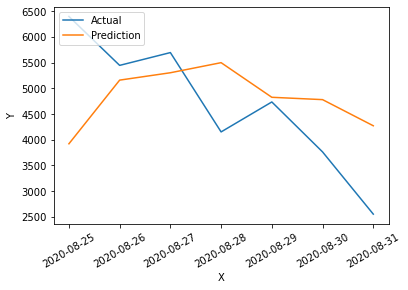




		Alpha = 0.8


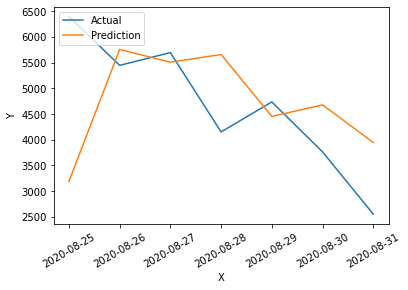




 ---------------  TN deaths  ----------------------  

         Date  Actual  Predicted_EWMA(0.5)  Predicted_EWMA(0.8)
0  2020-08-25     NaN            19.057459            18.333400
1  2020-08-26     NaN            29.528729            35.666680
2  2020-08-27     NaN            24.764365            23.133336
3  2020-08-28     NaN            24.882182            24.626667
4  2020-08-29     NaN            26.441091            27.325333
5  2020-08-30     NaN            25.220546            24.665067
6  2020-08-31     NaN            23.610273            22.533013 


   Alpha         MSE       MAPE
0    0.5  118.770719  35.428052
1    0.8  141.312164  39.397461 


		Alpha = 0.5


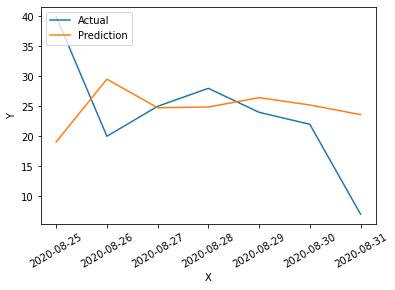




		Alpha = 0.8


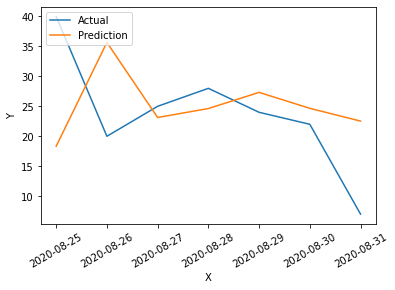




 ---------------  TX deaths  ----------------------  

         Date  Actual  Predicted_EWMA(0.5)  Predicted_EWMA(0.8)
0  2020-08-25     NaN            96.157597            45.529315
1  2020-08-26     NaN           138.578799           153.905863
2  2020-08-27     NaN           183.789399           213.981173
3  2020-08-28     NaN           224.394700           254.796235
4  2020-08-29     NaN           210.197350           207.759247
5  2020-08-30     NaN           182.098675           164.751849
6  2020-08-31     NaN           136.049337           104.950370 


   Alpha          MSE      MAPE
0    0.5  6646.687472  52.64619
1    0.8  6394.630060  77.10447 


		Alpha = 0.5


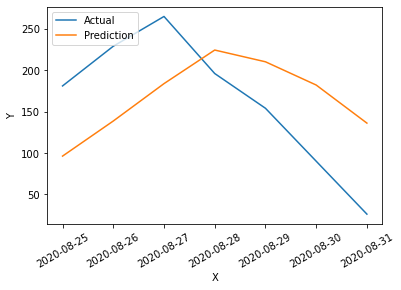




		Alpha = 0.8


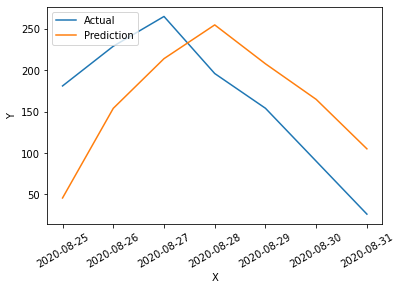

In [32]:
cols = ['TN confirmed', 'TX confirmed', 'TN deaths', 'TX deaths']
date = np.array(test['Date'])
for col in cols:

    y_predicted_point5, MSE_predicted_point5, MAPE_predicted_point5 = EWMA((states_df_2a[col]).tolist(),0.5)
    y_predicted_point8,MSE_predicted_point8, MAPE_predicted_point8  = EWMA((states_df_2a[col]).tolist(),0.8)

    df_ar1 = pd.DataFrame()
    actual = states_df_2a[col][-7:]
    df_ar1['Date'] = date
    df_ar1['Actual'] = actual
    df_ar1['Predicted_EWMA(0.5)'] = y_predicted_point5[-7:]
    df_ar1['Predicted_EWMA(0.8)'] = y_predicted_point8[-7:]
    print('\033[1m --------------- ',col,' ---------------------- \033[0m \n')
    print(df_ar1, '\n\n')
    
    df_ar2 = pd.DataFrame()
    df_ar2['Alpha'] = [0.5,0.8]
    df_ar2['MSE'] = MSE_predicted_point5, MSE_predicted_point8
    df_ar2['MAPE'] = MAPE_predicted_point5, MAPE_predicted_point8
    print(df_ar2, '\n\n')
    
    print("\t\tAlpha = 0.5")
    plotGraph(date, actual, y_predicted_point5[-7:])
    print('\n\n')
    
    print("\t\tAlpha = 0.8")
    plotGraph(date, actual, y_predicted_point8[-7:])
    print('\n\n')